# Check-worthiness detection using Large Language Models

First, the necessary python modules are imported

In [11]:
%load_ext autoreload
%autoreload

from claimbuster_utils import load_claimbuster_dataset
from checkthat_utils import load_check_that_dataset
import pandas as pd
from llm import load_huggingface_model, HuggingFaceModel, run_llm_cross_validation, generate_llm_predictions, ICLUsage, PromptType
from result_analysis import generate_error_analysis_report, print_padded_text, display_confusion_matrix
from dataset_utils import generate_cross_validation_datasets, CustomDataset
import ipywidgets as widgets
import os
from huggingface_hub import login
import pandas as pd
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Login to HuggingFace hub

In order to get access to the LLama2 model, you need to login to the Huggingace hub and have gated access to the model. Otherwise this can be skipped

In [7]:
login()

## Generate Cross Validation datasets

In [2]:
%autoreload
claimbuster = load_claimbuster_dataset("../data/ClaimBuster/datasets")
clambuster_datasets = generate_cross_validation_datasets(
    data=claimbuster, 
    folder_path="../data/ClaimBuster/crossval"
)

checkthat = load_check_that_dataset("../data/CheckThat")
checkthat_datasets = generate_cross_validation_datasets(
    data=checkthat, 
    label_column="check_worthiness",
    folder_path="../data/CheckThat/crossval"
)

## Generate predictions

Using ipywidgets to select which model, dataset, and other parameters to generate LLM predictions

In [2]:
%autoreload

# General lauyout
input_style = dict(
    description_width="fit-content"
)

# Dataset 
dataset_select = widgets.Dropdown(
    options=[("ClaimBuster", CustomDataset.CLAIMBUSTER), ("CheckThat", CustomDataset.CHECK_THAT)],
    value=CustomDataset.CLAIMBUSTER,
    description="Dataset:"
)

# Model and parameters
model_select = widgets.Dropdown(
    options=[
        ("Mistral 7B Instruct", HuggingFaceModel.MISTRAL_7B_INSTRUCT), 
        ("Mixtral Instruct", HuggingFaceModel.MIXTRAL_INSTRUCT),
        ("LLama 2 7B Chat", HuggingFaceModel.LLAMA2_7B_CHAT)],
    value=HuggingFaceModel.MISTRAL_7B_INSTRUCT,
    description="Model:",
    style=input_style
)
max_new_tokens_int_text = widgets.IntText(
    value=64,
    description="Max new tokens:",
    style=input_style
)
batch_size = widgets.IntText(
    value=128,
    description="Batch size:",
    style=input_style
)
model_and_parameters = widgets.VBox(
    [model_select, max_new_tokens_int_text, batch_size],
)

# Prompting type
prompting_type = widgets.Dropdown(
    options=[("Standard", PromptType.STANDARD), ("Chain-of-Thought", PromptType.CHAIN_OF_THOUGHT)],
    value=PromptType.STANDARD,
    description="Prompting type:",
    style=input_style
)
icl_usage = widgets.Dropdown(
    options=[("Zero-shot", ICLUsage.ZERO_SHOT), ("Few-shot", ICLUsage.FEW_SHOT)],
    value=ICLUsage.ZERO_SHOT,
    description="ICL usage:",
    style=input_style
)
prompt_use = widgets.VBox(
    [prompting_type, icl_usage]
)

accordion = widgets.Accordion([
    dataset_select,
    model_and_parameters,
    prompt_use
],
    titles=["Dataset", "Model and parameters", "Prompting type"],
)

title = widgets.HTML(
    "<h1>Generation of predictions using LLMs</h1>",
)
description = widgets.HTML(
    "<div>Set the parameters to select what dataset, model and prompting to use when generating predictions. If you experience Cuda out of memory issues, please decrease the batch size.</div>",
    layout={"font-size": '14px'}
)
start_generation_button = widgets.Button(
    description="Start generation",
    disabled=False,
    button_style="success",
    layout={"height": "40px", "width": "calc(100% - 4px)"},
)

def handle_generation_click(_):
    if dataset_select.value == CustomDataset.CLAIMBUSTER:
        dataset = load_claimbuster_dataset("../data/ClaimBuster/datasets")
        label_column = "Verdict"
        text_column = "Text"
    else:
        dataset = load_check_that_dataset("../data/CheckThat")
        label_column = "check_worthiness"
        text_column = "tweet_text"

    instruction_path = os.path.join(
        "../prompts",
        dataset_select.value.value,
        prompting_type.value.value,
        icl_usage.value.value,
        "instruction.txt"
    )
    print("#" * 50)
    print_padded_text("Starting generation with parameters")
    print_padded_text(f"Dataset: {dataset_select.value.value}")
    print_padded_text(f"Model: {model_select.value.name}")
    print_padded_text(f"Prompting type: {prompting_type.value.value}")
    print_padded_text(f"ICL usage: {icl_usage.value.value}")
    print("#" * 50)
    if not os.path.exists(instruction_path):
        print("No instruction found, exiting...")
        return
    with open(instruction_path, "r") as f:
        instruction = f.read().replace("\n", "")
    prompts = [ f"[INST]{instruction} '''{text}'''[/INST]" for text in dataset[text_column]]
    print("Loading model...")
    pipe = load_huggingface_model(
        model_id=model_select.value, 
        max_new_tokens=max_new_tokens_int_text.value
    )

    print("Generating predictions...")
    save_path = os.path.join(
        "../results",
        dataset_select.value.value,
        model_select.value.name,
        prompting_type.value.value,
        icl_usage.value.value,
        "generated_scores.csv"
    )
    with torch.no_grad():
        generate_llm_predictions(
            data=dataset,
            prompts=prompts,
            pipe=pipe,
            batch_size=batch_size.value,
            label_column=label_column,
            text_column=text_column,
            save_path=save_path
        )
        torch.cuda.empty_cache()


start_generation_button.on_click(handle_generation_click)


box = widgets.Box(
    [title, description, accordion, start_generation_button],
    layout=widgets.Layout(
        padding= '16px', 
        display= "flex", 
        flex_flow="column",
        align_items="stretch",
        border="1px solid black"
    )
) 
display(box)

Box(children=(HTML(value='<h1>Generation of predictions using LLMs</h1>'), HTML(value='<div>Set the parameters…

##################################################
#      Starting generation with parameters       #
#              Dataset: ClaimBuster              #
#             Model: LLAMA2_7B_CHAT              #
#            Prompting type: standard            #
#               ICL usage: fewshot               #
##################################################
Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

max_new_tokens=64
Generating predictions...


  0%|          | 0/9674 [00:00<?, ?it/s]

## Cross validation

Using ipywidgets to select what models to run cross validation on

In [ ]:
%autoreload

input_style = dict(
    description_width="fit-content"
)

dataset_select = widgets.Dropdown(
    options=[("ClaimBuster", CustomDataset.CLAIMBUSTER), ("CheckThat", CustomDataset.CHECK_THAT)],
    value=CustomDataset.CLAIMBUSTER,
    description="Dataset:"
)

model_select = widgets.Dropdown(
    options=[
        ("Mistral 7B Instruct", HuggingFaceModel.MISTRAL_7B_INSTRUCT), 
        ("Mixtral Instruct", HuggingFaceModel.MIXTRAL_INSTRUCT),
        ('LLama2 7B Chat', HuggingFaceModel.LLAMA2_7B_CHAT)
    ],
    value=HuggingFaceModel.MISTRAL_7B_INSTRUCT,
    description="Model:",
    style=input_style
)

prompting_type = widgets.Dropdown(
    options=[("Standard", PromptType.STANDARD), ("Chain-of-Thought", PromptType.CHAIN_OF_THOUGHT)],
    value=PromptType.STANDARD,
    description="Prompting type:",
    style=input_style
)
icl_usage = widgets.Dropdown(
    options=[("Zero-shot", ICLUsage.ZERO_SHOT), ("Few-shot", ICLUsage.FEW_SHOT)],
    value=ICLUsage.ZERO_SHOT,
    description="ICL usage:",
    style=input_style
)
prompt_use = widgets.VBox(
    [prompting_type, icl_usage]
)

title = widgets.HTML(
    "<h1>Cross validation using LLMs</h1>",
)
description = widgets.HTML(
    "<div>Set the parameters to select what dataset, model and prompting to use when performing cross validation.</div>",
    layout={"font-size": '14px'}
)
start_cross_validation_button = widgets.Button(
    description="Start cross validation",
    disabled=False,
    button_style="success",
    layout={"height": "40px", "width": "calc(100% - 4px)"},
)

def handle_cross_validation_click(_):
    dataset_folder = os.path.join(
        "../results",
        dataset_select.value.value,
        model_select.value.name,
        prompting_type.value.value,
        icl_usage.value.value,
    )
    dataset_path = os.path.join(dataset_folder, "generated_scores.csv")
    if not os.path.exists(dataset_path):
        print("No generated scores found")
        return
    dataset_with_scores = pd.read_csv(dataset_path, index_col=0)
    crossval_folder = os.path.join(
        "../data",
        dataset_select.value.value,
        "crossval"
    )
    label_column = "Verdict" if dataset_select.value == CustomDataset.CLAIMBUSTER else "check_worthiness"
    print("#" * 50)
    print_padded_text("Starting cross validation with parameters")
    print_padded_text(f"Dataset: {dataset_select.value.value}")
    print_padded_text(f"Model: {model_select.value.name}")
    print_padded_text(f"Prompting type: {prompting_type.value.value}")
    print_padded_text(f"ICL usage: {icl_usage.value.value}")
    print("#" * 50)
    result, _ = run_llm_cross_validation(
        data=dataset_with_scores, 
        crossval_folder=crossval_folder,
        save_folder=dataset_folder,
        label_column=label_column
    )
    display(result)

start_cross_validation_button.on_click(handle_cross_validation_click)

accordion = widgets.Accordion([
    dataset_select,
    model_select,
    prompt_use
],
    titles=["Dataset", "Model", "Prompting type"],
)

box = widgets.Box(
    [title, description, accordion, start_cross_validation_button],
    layout=widgets.Layout(
        padding= '16px', 
        display= "flex", 
        flex_flow="column",
        align_items="stretch",
        border="1px solid black"
    )
) 
display(box)

Box(children=(HTML(value='<h1>Cross validation using LLMs</h1>'), HTML(value='<div>Set the parameters to selec…

##################################################
#   Starting cross validation with parameters    #
#              Dataset: ClaimBuster              #
#           Model: MISTRAL_7B_INSTRUCT           #
#            Prompting type: standard            #
#              ICL usage: zeroshot               #
##################################################
self.threshold=41
             prediction
sentence_id            
19700               1.0
32496               1.0
15712               1.0
8466                1.0
32725               1.0
26076               1.0
8236                1.0
2316                1.0
27831               0.0
909                 0.0
             Verdict  score  \
sentence_id                   
19700              1   60.0   
32496              1   70.0   
15712              1   80.0   
8466               1  100.0   
32725              1   50.0   
26076              1  100.0   
8236               1   80.0   
2316               1   80.0   
27831              1    0.0

,accuracy,0_precision,0_recall,0_f1-score,1_precision,1_recall,1_f1-score,macro avg_precision,macro avg_recall,macro avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_f1-score
0,0.839603,0.902644,0.869213,0.885613,0.700662,0.765557,0.731674,0.801653,0.817385,0.808643,0.844947,0.839603,0.841640
1,0.828855,0.891071,0.866319,0.878521,0.687415,0.735166,0.710490,0.789243,0.800743,0.794505,0.832896,0.828855,0.830522
2,0.833333,0.903167,0.858715,0.880380,0.685567,0.769899,0.725290,0.794367,0.814307,0.802835,0.840983,0.833333,0.836059
3,0.836642,0.903636,0.863347,0.883032,0.692708,0.769899,0.729267,0.798172,0.816623,0.806149,0.843359,0.836642,0.839090
Average,0.834608,0.900130,0.864398,0.881887,0.691588,0.760130,0.724180,0.795859,0.812264,0.803033,0.840546,0.834608,0.836828


## Zero-shot classification

#### Using contextual features

In [ ]:
data = load_claimbuster_dataset(
    "../data/ClaimBuster/datasets",
    use_contextual_features=True,
    debate_transcripts_folder="../data/ClaimBuster/debate_transcripts",
)[:10]

contexts = data["previous_sentences"].tolist()
prompts = [
    f"{instruction} For context, the following senteces were said prior to the one in question: {context} Only evaluate the check-worthiness of the following sentence: '''{text}'''"
    for text, context in zip(texts, contexts)
]
zeroshot_output = "../results/ClaimBuster/{model_id.name}/zeroshot/zeroshot_contextual_preds.csv"

generate_llm_predictions(
    data=data,
    pipe=pipe, 
    prompts=prompts, 
    save_path=zeroshot_output
)

#### Error analysis

MISTRAL_7B_INSTRUCT standard zeroshot


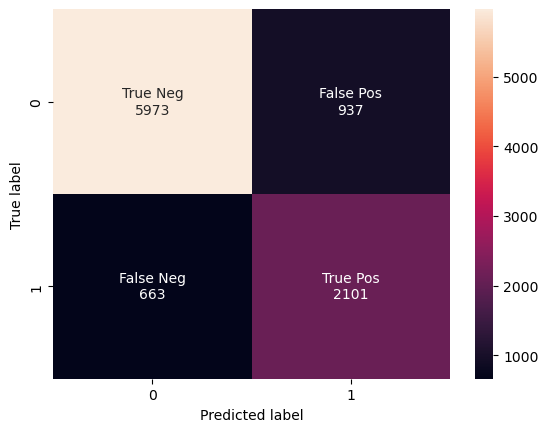

MISTRAL_7B_INSTRUCT standard fewshot


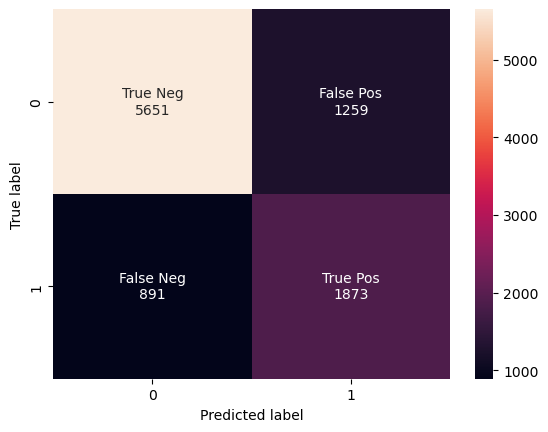

MIXTRAL_INSTRUCT standard zeroshot


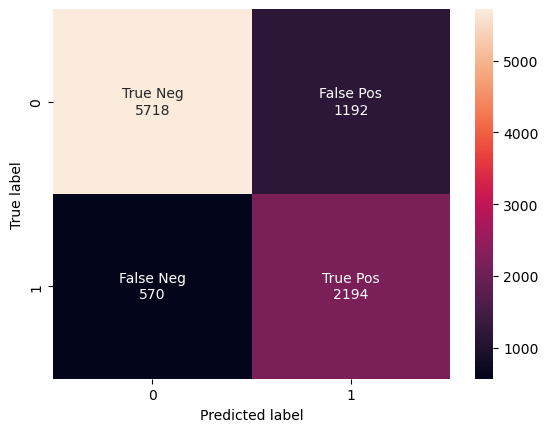

MIXTRAL_INSTRUCT standard fewshot


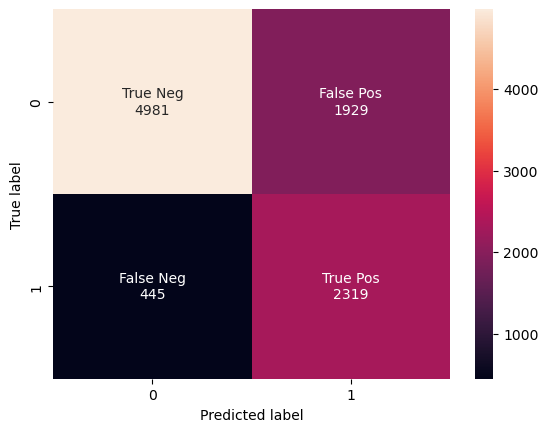

LLAMA2_7B_CHAT standard zeroshot


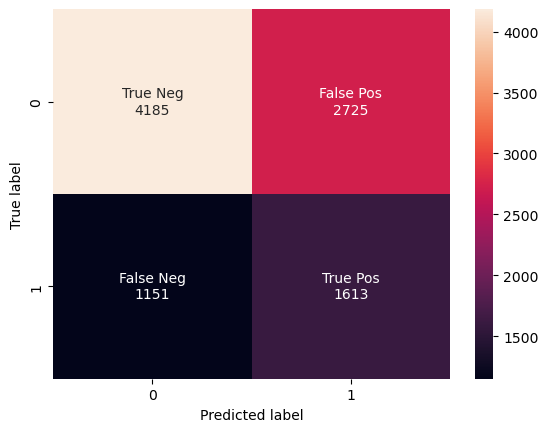

LLAMA2_7B_CHAT standard fewshot


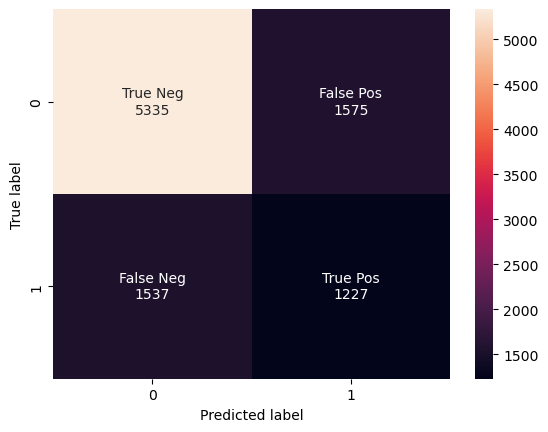

MISTRAL_7B_INSTRUCT LORA


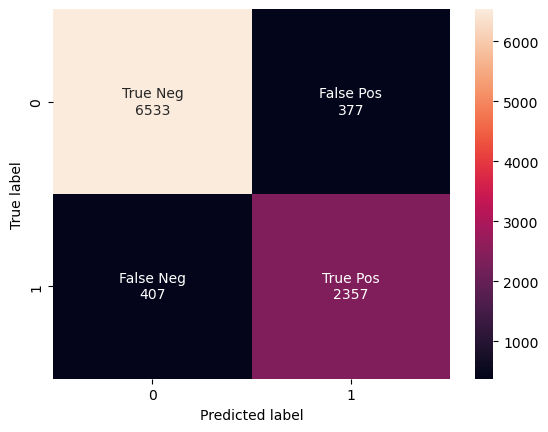

LLAMA2_7B_CHAT LORA


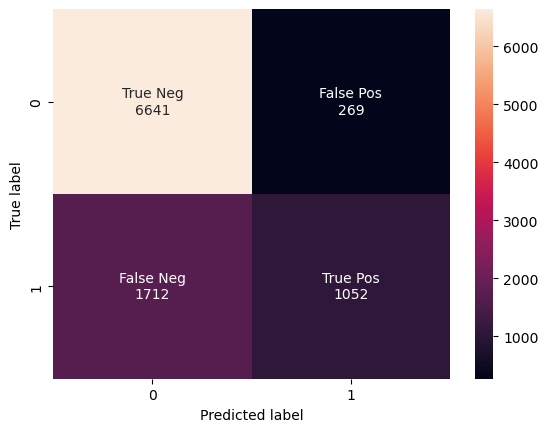

##################################################
#                     Total                      #
#             False positives: 4513              #
#             False negatives: 2518              #
#        Overlapping false positives: 10         #
#        Overlapping false negatives: 56         #
##################################################


In [40]:
%autoreload
predictions = []
models = [HuggingFaceModel.MISTRAL_7B_INSTRUCT, HuggingFaceModel.MIXTRAL_INSTRUCT, HuggingFaceModel.LLAMA2_7B_CHAT]
prompt_types = [PromptType.STANDARD, PromptType.CHAIN_OF_THOUGHT]
icl_usages = [ICLUsage.ZERO_SHOT, ICLUsage.FEW_SHOT]
model_names = []
claimbuster = load_claimbuster_dataset("../data/ClaimBuster/datasets")

for model, prompt_type, icl_usage in itertools.product(models, prompt_types, icl_usages):
    predictions_path = f"../results/ClaimBuster/{model.name}/{prompt_type.value}/{icl_usage.value}/predictions.csv"
    if os.path.exists(predictions_path):
        new_predictions = pd.read_csv(predictions_path, index_col=0)
        predictions.append(new_predictions) 
        model_name = f"{model.name} {prompt_type.value} {icl_usage.value}"
        model_names.append(model_name)
        print(model_name)
        display_confusion_matrix(
            claimbuster, 
            new_predictions.loc[claimbuster.index],
            save_path=os.path.join(os.path.dirname(predictions_path), "confusion-matrix.pdf")
        )
# LORA
for model in models:
    predictions_path = f"../results/ClaimBuster/{model.name}/lora/predictions.csv"
    if os.path.exists(predictions_path):
        new_predictions = pd.read_csv(predictions_path, index_col=0)
        predictions.append(new_predictions)
        model_name = f"{model.name} LORA"
        model_names.append(model_name)
        print(model_name)
        display_confusion_matrix(
            claimbuster, 
            new_predictions.loc[claimbuster.index]["prediction"],
            save_path=os.path.join(os.path.dirname(predictions_path), "confusion-matrix.pdf")
        )

generate_error_analysis_report(
    claimbuster,
    predictions=predictions,
    model_names=model_names,
    folder_path=f"../results/ClaimBuster"
)

### CheckThat 2021 Task 1a Tweets

#### Error analysis

MISTRAL_7B_INSTRUCT standard zeroshot


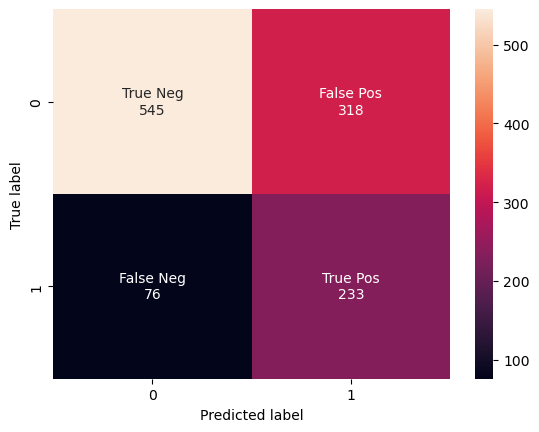

MISTRAL_7B_INSTRUCT standard fewshot


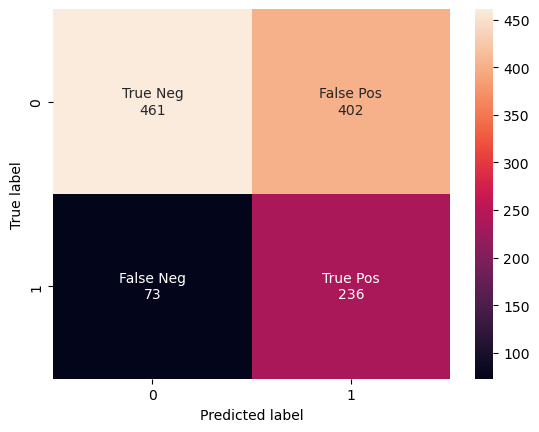

MISTRAL_7B_INSTRUCT CoT zeroshot


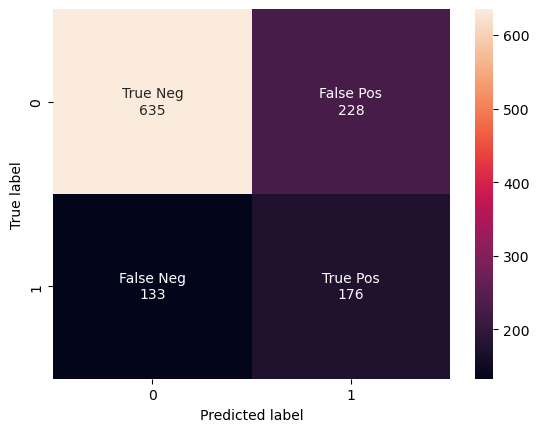

MIXTRAL_INSTRUCT standard zeroshot


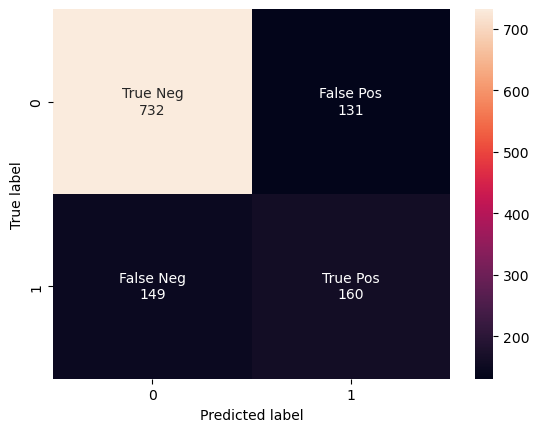

MIXTRAL_INSTRUCT standard fewshot


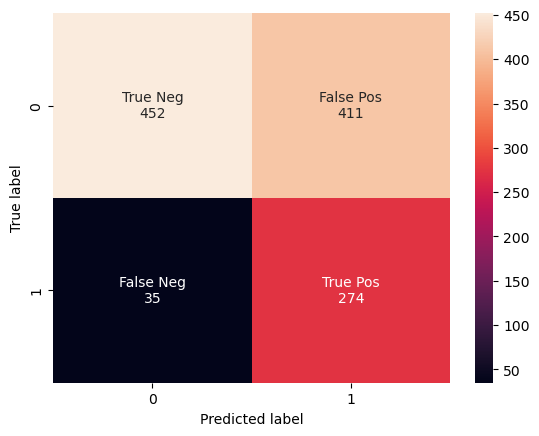

LLAMA2_7B_CHAT standard zeroshot


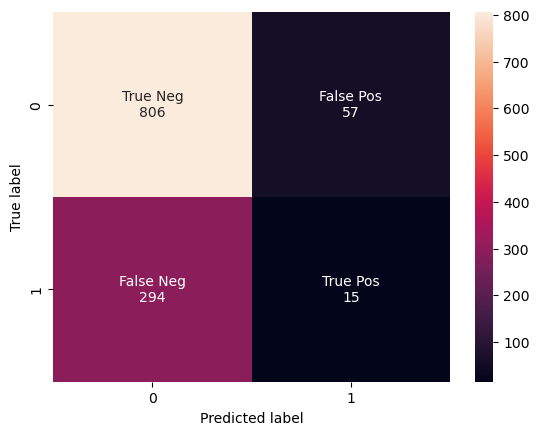

LLAMA2_7B_CHAT standard fewshot


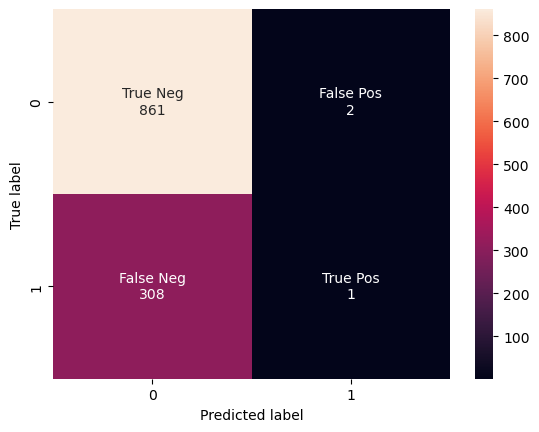

LLAMA2_7B_CHAT CoT zeroshot


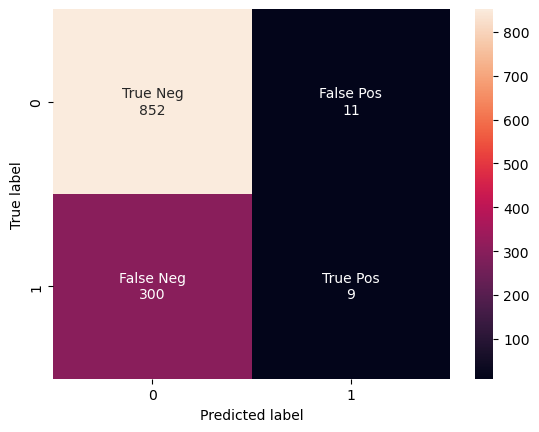

MISTRAL_7B_INSTRUCT LORA


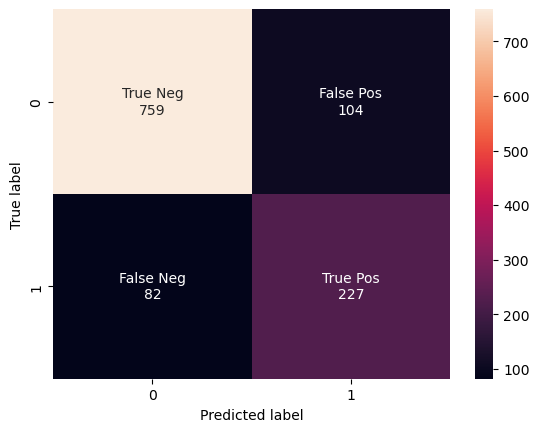

LLAMA2_7B_CHAT LORA


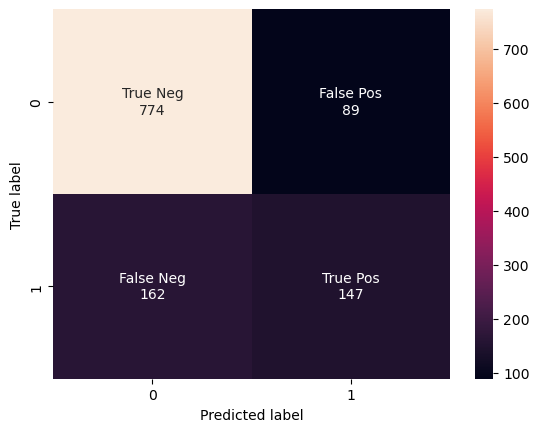

##################################################
#                     Total                      #
#              False positives: 601              #
#              False negatives: 309              #
#         Overlapping false positives: 0         #
#         Overlapping false negatives: 6         #
##################################################


In [43]:
%autoreload
predictions = []
models = [HuggingFaceModel.MISTRAL_7B_INSTRUCT, HuggingFaceModel.MIXTRAL_INSTRUCT, HuggingFaceModel.LLAMA2_7B_CHAT]
prompt_types = [PromptType.STANDARD, PromptType.CHAIN_OF_THOUGHT]
icl_usages = [ICLUsage.ZERO_SHOT, ICLUsage.FEW_SHOT]
model_names = []
checkthat = load_check_that_dataset("../data/CheckThat")

for model, prompt_type, icl_usage in itertools.product(models, prompt_types, icl_usages):
    predictions_path = f"../results/CheckThat/{model.name}/{prompt_type.value}/{icl_usage.value}/predictions.csv"
    if os.path.exists(predictions_path):
        new_predictions = pd.read_csv(predictions_path, index_col=0)
        predictions.append(new_predictions) 
        model_name = f"{model.name} {prompt_type.value} {icl_usage.value}"
        model_names.append(model_name)
        print(model_name)
        display_confusion_matrix(
            checkthat, 
            new_predictions.loc[checkthat.index],
            label_column_name="check_worthiness",
            save_path=os.path.join(os.path.dirname(predictions_path), "confusion-matrix.pdf")
        )
# LORA
for model in models:
    predictions_path = f"../results/CheckThat/{model.name}/lora/predictions.csv"
    if os.path.exists(predictions_path):
        new_predictions = pd.read_csv(predictions_path, index_col=0)
        predictions.append(new_predictions)
        model_name = f"{model.name} LORA"
        model_names.append(model_name)
        print(model_name)
        display_confusion_matrix(
            checkthat, 
            new_predictions.loc[checkthat.index]["prediction"],
            label_column_name="check_worthiness",
            save_path=os.path.join(os.path.dirname(predictions_path), "confusion-matrix.pdf")
        )

generate_error_analysis_report(
    checkthat,
    predictions=predictions,
    model_names=model_names,
    folder_path="../results/CheckThat",
    label_column_name="check_worthiness",
    text_column_name="tweet_text",
)

## Relating truthfulness and check-worthiness

Running check-worthiness detection on the LIAR dataset by fine-tuning an LLM on the ClaimBuster dataset.

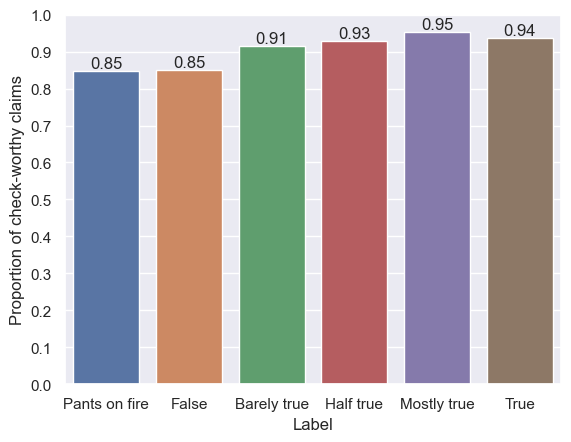

In [91]:
%autoreload

from liar_utils import LIARLabel
from plotting_utils import show_bar_plot
liar = pd.read_csv("../results/LIAR/checkworthiness.csv", index_col=0)
liar.head()
label_to_name = {
    LIARLabel.PANTS_FIRE: "Pants on fire",
    LIARLabel.FALSE: "False",
    LIARLabel.BARELY_TRUE: "Barely true",
    LIARLabel.HALF_TRUE: "Half true",
    LIARLabel.MOSTLY_TRUE: "Mostly true",
    LIARLabel.TRUE: "True"
}
x = [label_to_name[label] for label in LIARLabel]
y = [liar[liar["label"] == label.value]["check_worthiness"].mean() for label in LIARLabel]
file_path = f"../figures/liar/checkworthiness/checkworthiness.png"

os.makedirs(os.path.dirname(file_path), exist_ok=True)
show_bar_plot(
    x, 
    y, 
    xlabel="Label", 
    ylabel="Proportion of check-worthy claims", 
    y_ticks=[i*0.1 for i in range(11)],
    file_path=file_path, 
    force_save=True,
    use_bar_labels=True,
)

# Look for non-checkworthy claims for each label
non_checkworthy_folder = "../results/LIAR/non-checkworthy"
os.makedirs(non_checkworthy_folder, exist_ok=True)
checkworthy_folder = "../results/LIAR/checkworthy"
os.makedirs(checkworthy_folder, exist_ok=True)
for label in LIARLabel:
    non_checkworthy = liar.query(f"label == {label.value} and check_worthiness == 0")
    non_checkworthy.to_csv(f"{non_checkworthy_folder}/{label.name}.csv")
    checkworthy = liar.query(f"label == {label.value} and check_worthiness == 1")
    checkworthy.to_csv(f"{checkworthy_folder}/{label.name}")